In [60]:
# all imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.utils import resample




In [40]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')

########################################################################################

# print(TEST_IMG)
# print(TRAIN_IMG)
# print(TRAIN_DATASE_CSV)

In [41]:
# get train/test image list
train_imgs = os.listdir(TRAIN_IMG_DIR)
test_imgs = os.listdir(TEST_IMG_DIR)

# print(f"{train_imgs[:10]}")
# print(f"{test_imgs[:10]}")

In [42]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)
df_backup = df
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# seems to work
# def combine_encoded_pixels(group):
#     if group.isna().all():
#         return np.nan
#     return ' '.join(filter(None, group))

# df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(combine_encoded_pixels)

df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
    lambda x: np.nan if x.isna().all() else ' '.join(filter(None, x))
)

# df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
#     lambda x: np.nan if x.isna().all() else ' '.join(pd.Series(x.dropna().unique()))
# )

df = df.drop_duplicates(subset='ImageId', keep='first')
df = df.drop(columns=['EncodedPixels'])
df = df.reset_index(drop=True)


df.head()


,ImageId,has_ship,ship_count,AllEncodedPixels
0,00003e153.jpg,0,0,NaN
1,0001124c7.jpg,0,0,NaN
2,000155de5.jpg,1,1,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,1,5,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,0,0,NaN


In [44]:
# check the results of the previous operations

tst = df[df['ImageId'] == '000194a2d.jpg']['AllEncodedPixels'].tolist()
print(tst)

['360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165 9 368933 10 369702 10 370471 9 371240 9 372009 9 372777 10 373546 9 374315 9 375084 7 375852 6 376621 3 377390 1 51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 61050 9 61818 9 62586 9 63354 9 64122 9 64890 9 198320 10 199088 10 199856 10 200624 10 201392 10 202160 10 202928 10 203696 10 204464 10 205232 10 206000 10 206768 10 207536 10 208304 10 209072 10 209840 10 210608 10 211376 10 212144 10 212912 10 213680 10 214448 10 215216 10 215984 10 216751 10 217519 10 218287 10 219055 10 219823 10 220591 10 221359 10 222127 10 222895 10 223663 10 224431 10 225199 10 225967 10 226735 10 227503 10 228271 10 229039 10 229807 10 230575 10 231343 10 232111 10 232879 10 233647 10 234415 10 55683 1 56451 1 57219 1 57987 1 58755 1 59523 1 60291 1 254389 9 255157 17 255925 17 256693 17 257461 17 258229 17 258997 17 259765 17 260533 17 261301 17 26206

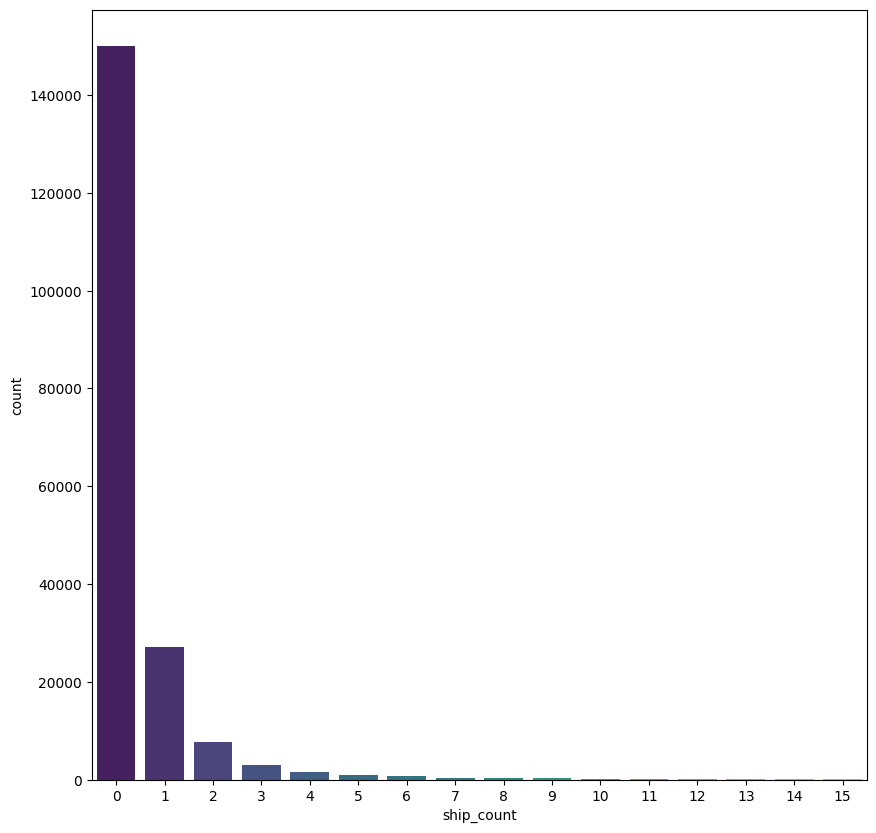

In [52]:
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=df, palette='viridis')
plt.show()

In [58]:

value_counts = df['ship_count'].value_counts()
print(value_counts)


ship_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64


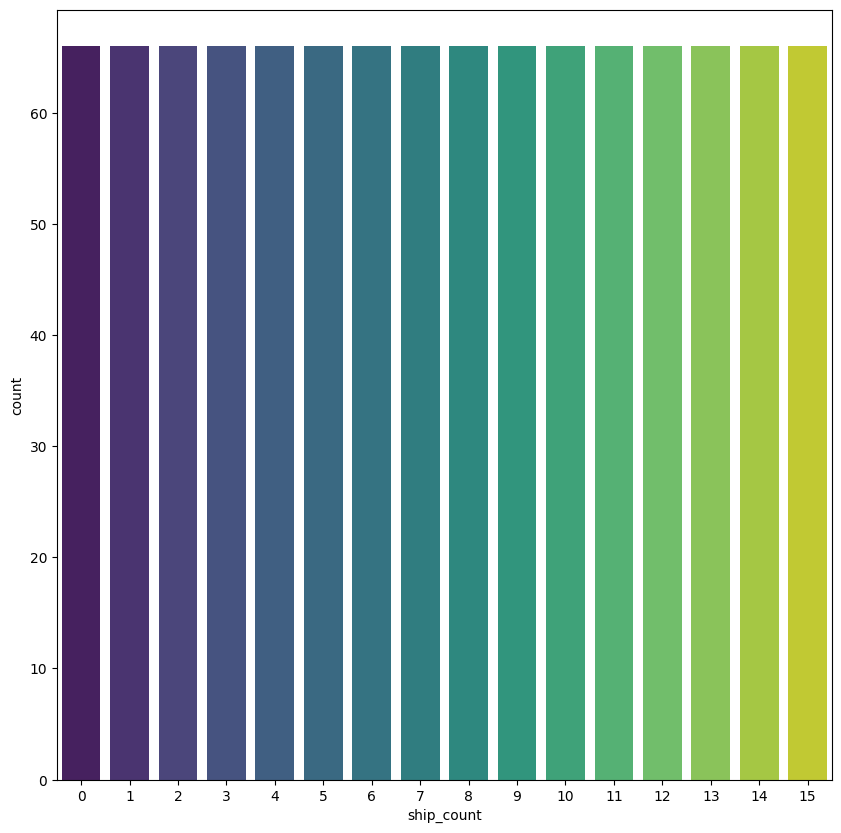

In [67]:
# NUM_SAMPLES = 200
NUM_SAMPLES = value_counts.min()

balanced_df = pd.DataFrame()

for value in value_counts.index:
    subset = df[df['ship_count'] == value]
    number_samples = NUM_SAMPLES if NUM_SAMPLES < len(subset) else len(subset)
#     print(f"subset len - {len(subset)}")
    resampled_subset = resample(subset, replace=False, n_samples=number_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_subset])

plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=balanced_df, palette='viridis')
plt.show()
